Make a chart showing the running total of fatality crashes by year. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib._color_data import BASE_COLORS, TABLEAU_COLORS, CSS4_COLORS, XKCD_COLORS
from datetime import datetime, timedelta
import pytz
import inflect
p = inflect.engine()

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

from crash_data_analysis import CrashDataAnalysis

In [2]:
%%time
cda = CrashDataAnalysis()
df = cda.crash_dataframe(
    verbose=True
#     , csv_file='data/denver_crashes_2022_11_05__10_01.csv'
)

Reading file: data/denver_crashes_2023_01_04__09_00.csv
Max timestamp: Mon Jan 2, 10:23 PM (1.64 days ago)
Deadly crashes this year: 0
CPU times: user 9.41 s, sys: 639 ms, total: 10.1 s
Wall time: 10.7 s


In [3]:
df = df[df.reported_date.dt.year < 2023].copy()

# Aggregate fatality crashes by year and day of year

crashes_by_day_of_year = pd.pivot_table(
    data=df
    , values='fatality'
    # , values='sbi_or_fatality'
    # , values='one'
    , index='crash_day_of_year'
    , columns='crash_year'
    , aggfunc='sum'
    , fill_value=None
    )

running_total_crashes = crashes_by_day_of_year.cumsum()

this_year = df.reported_date.max().year
max_day_of_year = df.reported_date.max().day_of_year

In [4]:
# Determine the number of days in each year. 365 normally, 366 for leap years

days_in_year = pd.Series(index=sorted(df.crash_year.unique()), dtype=int)

for year in sorted(df.crash_year.unique()):
    
    if year == this_year:
        days_in_year.loc[year] = max_day_of_year

    else:
        days_in_year.loc[year] = pd.Timestamp(year, 12, 31).dayofyear

# Series showing the total number of days in each year, for trendline chart
total_days_in_year = days_in_year.copy()
total_days_in_year.loc[this_year] = pd.Timestamp(this_year, 12, 31).dayofyear

In [5]:
# Make DataFrame with info about every month

first_of_month = pd.DataFrame({'month_int': range(1,13)})
first_of_month['month_str'] = first_of_month.apply(
    lambda row: pd.Timestamp(this_year, row.month_int, 1).strftime('%b'), axis=1)
first_of_month['day_of_year'] = first_of_month.apply(
    lambda row: pd.Timestamp(this_year, row.month_int, 1).day_of_year, axis=1)

first_of_month['label'] = first_of_month['month_str'] + '\n1'
first_of_month.loc[12, 'month_int'] = 13
first_of_month.loc[12, 'label'] = 'EOY'
first_of_month.loc[12, 'day_of_year'] = 366

In [6]:
fatality_crashes_by_year = df.groupby('crash_year').fatality.sum()

In [7]:
fatality_crash_per_day = fatality_crashes_by_year / days_in_year

projected_fatality_crashes_by_year = fatality_crashes_by_year.astype(float).copy()
projected_fatality_crashes_by_year[this_year] = (
    fatality_crash_per_day[this_year] * pd.Timestamp(this_year, 12, 31).dayofyear
)

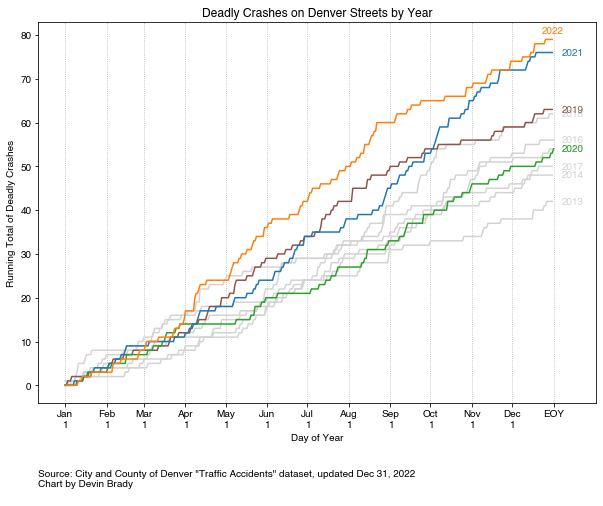

In [8]:
# Make the running total chart
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(10,7))

max_x_value = 380
plt.plot(range(0, max_x_value), [1] * max_x_value, alpha=0)

for year in sorted(df.crash_year.unique()):
    if year == 2019:
        color = 'tab:brown'
    elif year == 2020:
        color = 'tab:green'
    elif year == 2021:
        color = 'tab:blue'
    elif year == 2022:
        color = 'tab:orange'
    else:
        color = 'lightgray'
        
    plt.plot(running_total_crashes[year], label=year, color=color)
    
    # trendline
#     plt.plot(
#         [0, total_days_in_year[year]]
#         , [0, projected_fatality_crashes_by_year[year]]
#         , color=color
#         , linestyle=':'
#     )
    
    if year == this_year:
        annotation_x = max_day_of_year
        annotation_y = max(running_total_crashes[year]) + 2
    else:
        annotation_x = max_x_value
        annotation_y = max(running_total_crashes[year])

    ax.annotate(
        xy=(annotation_x, annotation_y)
        , text=year
        , color=color
        , fontweight='bold'
        , horizontalalignment='center'
        , verticalalignment='center'
    )

    
plt.xticks(ticks=first_of_month['day_of_year'], labels=first_of_month['label'])
plt.grid(axis='x', linestyle=':')

citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset, updated {df.reported_date.max().strftime('%b %-d, %Y')}
Chart by Devin Brady
"""

ax.annotate(xy=(0, -0.2), text=citation, xycoords='axes fraction', ha='left', va='center')
plt.xlabel('Day of Year')
plt.ylabel('Running Total of Deadly Crashes')
plt.title('Deadly Crashes on Denver Streets by Year')
_ = plt.savefig(
    'images/deadly_crashes_running_total.png', transparent=False, facecolor='white', bbox_inches='tight')

## Counts

In [9]:
fatality_crashes_by_year

crash_year
2013    42
2014    48
2015    54
2016    56
2017    50
2018    62
2019    63
2020    54
2021    76
2022    79
Name: fatality, dtype: int64

crash_year
2013    42.0
2014    48.0
2015    54.0
2016    56.0
2017    50.0
2018    62.0
2019    63.0
2020    53.0
2021    76.0
2022    79.0
Name: 365, dtype: float64

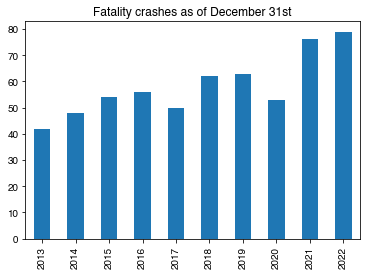

In [10]:
# Fatality crashes as of this day in the year
running_total_crashes.loc[max_day_of_year].plot(kind='bar')

date_string = df.reported_date.max().strftime('%B ')
date_string += p.ordinal(df.reported_date.max().strftime('%-d'))

plt.title(f"Fatality crashes as of {date_string}")

_ = plt.xlabel('')

running_total_crashes.loc[max_day_of_year]

In [11]:
days_per_fatality_crash = days_in_year / fatality_crashes_by_year
days_per_fatality_crash

2013    8.690476
2014    7.604167
2015    6.759259
2016    6.535714
2017    7.300000
2018    5.887097
2019    5.793651
2020    6.777778
2021    4.802632
2022    4.620253
dtype: float64

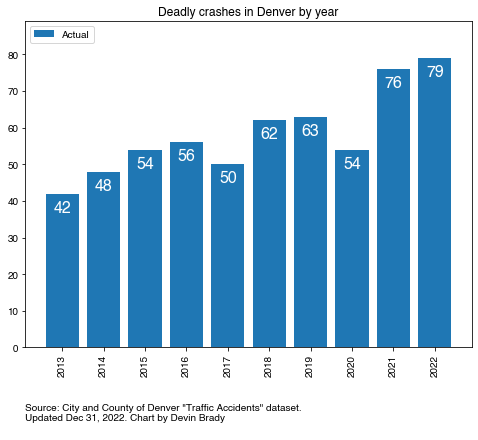

In [12]:
# Fatality crashes per year, current year projected
fig, ax = plt.subplots(figsize=(8,6))

# ax.bar(
#     x=this_year
#     , height=projected_fatality_crashes_by_year[this_year]
#     , hatch='///'
#     , fill=False
#     , edgecolor=TABLEAU_COLORS['tab:blue']
#     , label='Projected'
# )

ax.bar(
    x=fatality_crashes_by_year.index
    , height=fatality_crashes_by_year
    , color=TABLEAU_COLORS['tab:blue']
    , label='Actual'
)

ax.set_xticks(fatality_crashes_by_year.index, fontcolor='white')

for year in sorted(df.crash_year.unique()):
    plt.text(
        x=year
        , y=fatality_crashes_by_year[year] - 5
        , s=fatality_crashes_by_year[year]
        , ha='center'
        , color='white'
        , fontsize=16
        , fontweight='bold'
    )

#     if year == this_year:
#         plt.text(
#             x=year
#             , y=projected_fatality_crashes_by_year[year] + 1
#             , s='{:.1f}'.format(projected_fatality_crashes_by_year[year])
#             , ha='center'
#             , color=TABLEAU_COLORS['tab:blue']
#             , fontsize=16
#             , fontweight='bold'
#         )

plt.ylim([0, projected_fatality_crashes_by_year[this_year] + 10])
# ax.tick_params(axis='x' ,direction='in', pad=-50, rotation=90, colors='white', labelsize=16)
# ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', rotation=90) 
plt.title(f'Deadly crashes in Denver by year')

citation = f"""
Source: City and County of Denver "Traffic Accidents" dataset.
Updated {df.reported_date.max().strftime('%b %-d, %Y')}. Chart by Devin Brady
"""

ax.annotate(xy=(0, -0.2), text=citation, xycoords='axes fraction', ha='left', va='center')

handles, labels = plt.gca().get_legend_handles_labels()
# order = [1,0]
order = [0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left')

_ = plt.savefig('images/deadly_crashes_barplot.png', transparent=False, facecolor='white', bbox_inches='tight')

## Deadly Crashes as a percentage of overall crashes

Is there deviation between these two metrics?

In [13]:
monthly_crash_rate = df.groupby(df.reported_date.dt.strftime('%Y-%m')).agg(
    crashes=('one', sum)
    , deadly_crashes=('fatality', sum)
)

monthly_crash_rate['crashes_per_deadly_crash'] = monthly_crash_rate['crashes'] / monthly_crash_rate['deadly_crashes']
monthly_crash_rate['deadly_crash_perc'] = monthly_crash_rate['deadly_crashes'] / monthly_crash_rate['crashes']

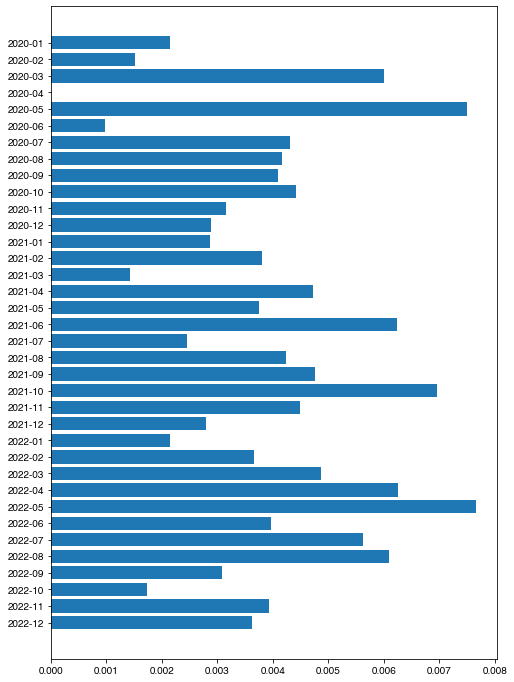

In [14]:
# monthly_crash_rate['crashes_per_deadly_crash'].tail(24).plot(type='bar')
fig, ax = plt.subplots(figsize=(8,12))

data_to_plot = monthly_crash_rate['deadly_crash_perc'].tail(36).iloc[::-1]

_ = ax.barh(
    y = data_to_plot.index
    , width = data_to_plot
)

## Year Thresholds

At what day in the current year are we matching the number of deadly crashes from previous years?

In [15]:
date_surpassed = pd.DataFrame(fatality_crashes_by_year)
date_surpassed.rename(columns={'fatality': 'deadly_crashes'}, inplace=True)
date_surpassed['date_surpassed_this_year'] = None

for year in date_surpassed.index:

    if date_surpassed.loc[this_year, 'deadly_crashes'] > date_surpassed.loc[year, 'deadly_crashes']:        
        day_of_year = int(
            running_total_crashes[
                running_total_crashes[this_year] > date_surpassed.loc[year, 'deadly_crashes']
            ].index.min()
        )
        date_this_year = (datetime(this_year, 1, 1) + timedelta(day_of_year - 1)).strftime('%B %-d, %Y')
        date_surpassed.loc[year, 'date_surpassed_this_year'] = date_this_year

date_surpassed.drop(index=this_year, inplace=True)
date_surpassed

,deadly_crashes,date_surpassed_this_year
crash_year,,
2013,42,"July 2, 2022"
2014,48,"July 25, 2022"
2015,54,"August 13, 2022"
2016,56,"August 18, 2022"
2017,50,"August 3, 2022"
2018,62,"September 14, 2022"
2019,63,"September 17, 2022"
2020,54,"August 13, 2022"
2021,76,"December 18, 2022"


## Recent deadly crashes

In [16]:
f = cda.recent_deadly_crashes(df)

                    incident_address              neighborhood_id       crash_time_str  days_between   days_ago
               4100 BLOCK E SMITH RD          Northeast Park Hill Mon Aug 22, 11:50 PM      0.077083 134.621122
     S SHERIDAN BLVD / W HAMPDEN AVE                   Fort Logan  Mon Sep 5, 12:25 AM     13.024306 121.596816
               5000 BLOCK W 10TH AVE                   Villa Park   Tue Sep 6, 3:27 AM      1.126389 120.470427
            N ALCOTT ST / W 38TH AVE                     Highland Wed Sep 14, 11:17 PM      8.826389 111.644038
   S QUEBEC ST / E CHERRY CREEK S DR             Virginia Village  Sat Sep 17, 1:02 PM      2.572917 109.071122
         E 46TH AVE / N FAIRPLAY WAY                    Montbello  Sat Sep 24, 1:19 PM      7.011806 102.059316
                  1700 BLOCK 19TH ST                Union Station Wed Oct 12, 11:53 PM     18.440278  83.619038
              2400 BLOCK N ROSLYN ST                 Central Park  Fri Oct 28, 1:04 AM     15.049306  68

## One Crash

All of the info about one crash.

In [17]:
df[df.incident_id == 2022631618].squeeze()

incident_id                                         2022631618
top_traffic_accident_offense    TRAF - ACCIDENT - FATAL       
reported_date                        2022-12-09 20:31:00-07:00
incident_address                  N SHERIDAN BLVD / W 38TH AVE
geo_lon                                            -105.053243
geo_lat                                               39.76932
neighborhood_id                                            NaN
bicycle_ind                                                1.0
pedestrian_ind                                             0.0
SERIOUSLY_INJURED                                          NaN
FATALITIES                                                 NaN
sbi                                                      False
fatality                                                  True
sbi_or_fatality                                           True
crash_date_str                                  2022-12-09 Fri
crash_time_str                              Fri Dec 9, 

## Crashes on streets where traffic calming was removed

Traffic-calming jersey barriers were removed from E 16th Ave around Monday, June 8, 2022. Source: Devin's photos 

Through traffic was restored to E 17th Ave on Tuesday, June 9, 2022. [Source](https://www.denvergov.org/Government/Agencies-Departments-Offices/Agencies-Departments-Offices-Directory/Department-of-Transportation-and-Infrastructure/Programs-Services/Projects/16th-Ave-Storm#:~:text=We%20do%20anticipate%20increased%20traffic,in%20place%20until%20March%202022.)

In [18]:
longitude_york = -104.95978236506068
longitude_colorado = -104.94071722366886

In [19]:
df.loc[
    (df.incident_address.str.contains('E 16TH AVE'))
    & (df.geo_lon < longitude_york)
    , ['incident_address', 'crash_time_str', 'top_traffic_accident_offense']
].tail(10)

,incident_address,crash_time_str,top_traffic_accident_offense
1861,1702 E 16TH AVE,"Mon Oct 17, 3:24 PM",TRAF - ACCIDENT
518,E 16TH AVE / N PEARL WASHINGTON ALY,"Tue Oct 18, 3:57 PM",TRAF - ACCIDENT - POLICE
1681,N GILPIN ST / E 16TH AVE,"Sun Oct 23, 12:05 PM",TRAF - ACCIDENT
17398,1200 BLOCK E 16TH AVE,"Tue Oct 25, 12:32 PM",TRAF - ACCIDENT
23409,E 16TH AVE / N WASHINGTON ST,"Mon Nov 21, 4:24 AM",TRAF - ACCIDENT - SBI
18133,2100 BLOCK E 16TH AVE,"Wed Nov 30, 2:20 PM",TRAF - ACCIDENT
19059,E 16TH AVE / N GRANT ST,"Sun Dec 4, 12:05 PM",TRAF - ACCIDENT
21774,E 16TH AVE / N LINCOLN ST,"Wed Dec 7, 9:30 AM",TRAF - ACCIDENT
18392,E 16TH AVE / N LOGAN ST,"Mon Dec 12, 2:31 PM",TRAF - ACCIDENT
18746,E 16TH AVE / N GILPIN ST,"Tue Dec 27, 6:32 AM",TRAF - ACCIDENT - HIT & RUN


In [20]:
df.loc[
    (df.incident_address.str.contains('E 17TH AVE'))
    & (df.geo_lon > longitude_york)
    & (df.geo_lon < longitude_colorado)
    , ['incident_address', 'crash_time_str', 'top_traffic_accident_offense']
].tail(10)

,incident_address,crash_time_str,top_traffic_accident_offense
19793,3628 E 17TH AVE,"Sun Jun 26, 3:10 AM",TRAF - ACCIDENT
5001,E 17TH AVE / N JOSEPHINE ST,"Wed Aug 10, 11:37 AM",TRAF - ACCIDENT
574,3030 E 17TH AVE,"Wed Sep 14, 4:42 PM",TRAF - ACCIDENT - HIT & RUN
2389,E 17TH AVE / N ADAMS ST,"Sun Sep 25, 12:27 AM",TRAF - ACCIDENT
1237,3400 BLOCK E 17TH AVE,"Tue Sep 27, 2:28 PM",TRAF - ACCIDENT
22403,E 17TH AVE / N HARRISON ST,"Wed Oct 26, 9:12 AM",TRAF - ACCIDENT
22061,3200 BLOCK E 17TH AVE,"Sat Nov 19, 12:07 AM",TRAF - ACCIDENT - HIT & RUN
18404,E 17TH AVE / N STEELE ST,"Sat Nov 26, 3:38 PM",TRAF - ACCIDENT - HIT & RUN
18741,E 17TH AVE / N FILLMORE ST,"Wed Dec 7, 5:14 PM",TRAF - ACCIDENT
19209,E 17TH AVE / N GARFIELD ST,"Fri Dec 16, 12:06 PM",TRAF - ACCIDENT - HIT & RUN


## Pedestrian and Bicyclist crashes

In [21]:
df.groupby('crash_year')['bicycle_ind', 'pedestrian_ind'].sum()

,bicycle_ind,pedestrian_ind
crash_year,,
2013,323.0,555.0
2014,337.0,530.0
2015,346.0,562.0
2016,315.0,530.0
2017,324.0,538.0
2018,318.0,546.0
2019,283.0,520.0
2020,196.0,323.0
2021,162.0,456.0


In [22]:
df.groupby(df.reported_date.dt.strftime('%Y-%m'))['bicycle_ind', 'pedestrian_ind'].sum().tail(20)

,bicycle_ind,pedestrian_ind
reported_date,,
2021-05,17.0,22.0
2021-06,22.0,41.0
2021-07,16.0,31.0
2021-08,16.0,39.0
2021-09,25.0,53.0
2021-10,14.0,69.0
2021-11,16.0,58.0
2021-12,8.0,38.0
2022-01,6.0,25.0


Alt text

Line chart showing the running total for deadly crashes on Denver streets by year. The orange line shows 2022, it is far above other years, and curving upwards in the last few days. 

Bar plot showing the total number of deadly crashes by year in Denver. 2022 is projected to have 93.2 deadly crashes as of yesterday. 

## Save smaller file to CSV for Google My Maps

Maximum number of points is 2,000

Map: https://www.google.com/maps/d/edit?mid=1Cn1TekkCt5BUYC-X3EMAvmmqPY0Aj30&ll=39.75925871700066%2C-104.88997345&z=11

In [23]:
my_maps_columns = [
    'incident_id'
    , 'top_traffic_accident_offense'
    , 'reported_date'
    , 'incident_address'
    , 'geo_lon'
    , 'geo_lat'
]

# df.loc[df.fatality & df.geo_lon.notnull() & df.geo_lat.notnull(), my_maps_columns].to_csv(
#     'data/deadly_crashes_to_google_my_maps.csv', index=False)

In [24]:
df[['fatality', 'sbi_or_fatality']].sum()

fatality            584
sbi_or_fatality    3918
dtype: int64

In [25]:
print(citation)


Source: City and County of Denver "Traffic Accidents" dataset.
Updated Dec 31, 2022. Chart by Devin Brady



## Number each deadly crash

In [26]:
# df.sort_values(['id', 'msg_ts'], ascending=True).groupby(['id', 'topic']).cumcount() + 1
df['crash_num'] = df[df.fatality].groupby(['crash_year']).cumcount() + 1

In [27]:
df[(df.reported_date.dt.year == 2022) & (df.fatality)][['incident_address', 'crash_time_str', 'crash_num']]

,incident_address,crash_time_str,crash_num
10435,5200 BLOCK PENA BLVD INBOUND,"Tue Jan 11, 2:18 PM",1.0
9980,E ALAMEDA AVE / S DAYTON ST,"Fri Jan 14, 12:17 PM",2.0
219240,1800 BLOCK S FEDERAL BLVD,"Fri Jan 21, 11:19 PM",3.0
16765,600 BLOCK S ELIOT ST,"Sun Feb 6, 2:04 AM",4.0
16774,I25 HWYNB / W COLFAX AVE,"Sun Feb 6, 11:24 AM",5.0
...,...,...,...
18730,N SHERIDAN BLVD / W 38TH AVE,"Fri Dec 9, 8:31 PM",75.0
18661,I25 HWYNB / E QUINCY AVE,"Thu Dec 15, 7:46 PM",76.0
22813,N FEDERAL BLVD / W 35TH AVE,"Sun Dec 18, 2:23 PM",77.0
22821,300 BLOCK N MEADE ST,"Sun Dec 18, 4:39 PM",78.0
